# Project

In [ ]:
import tdmclient.notebook
await tdmclient.notebook.stop()

In [1]:
import numpy as np
import math
import time
from computer_vision import *
from dijkstra import compute_shortest_path
from kalman import kalman_filter
from test import *
#import tdmclient.notebook
#await tdmclient.notebook.start()

# Main 

1
2
3
0
cv successful:  True
robot :  [146, 397, 0.4457123126286356] [0, 0]
goal  :  [1172, 487]
obst  :  [[(901, 594), (892, 863), (1117, 739)], [(417, 327), (453, 612), (583, 447)], [(745, 264), (814, 400), (989, 328)]]


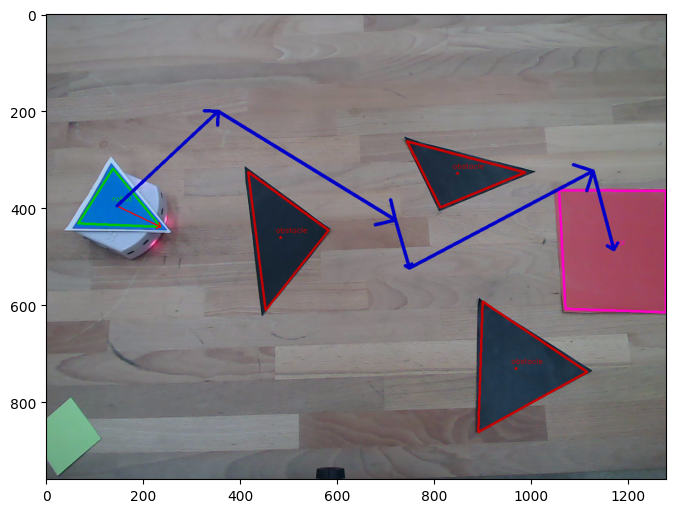

In [2]:
fig, ax = plt.subplots(figsize=(8,8))
video_capture, cv_successful, obst, robot, goal, frame = cv_start(show_image= True, exposure=-7)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
obst = format_contour(obst)

metric_robot = pixel_to_metric(robot[:2])
print("cv successful: ", cv_successful)
print("robot : ", robot , metric_robot)
print("goal  : ", goal)
print("obst  : ", obst)

if cv_successful:
    start = np.array([robot[0],robot[1]])
    path = compute_shortest_path(obst, start, goal)
    path = np.rint(path).astype(int)
    frame = draw_path(frame, path) 
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))


In [ ]:
position_estimate =  start
theta_estimate = 0
path = np.delete(path, 0, 0)
plt.gca().invert_yaxis()
for tar in path:
    pos_hist, thet_hist = pathing(position_estimate, theta_estimate, tar, min_distance=30)
    if pos_hist is not None and thet_hist is not None:
        position_estimate = pos_hist[-1]
        theta_estimate = thet_hist[-1]
    
    plt.plot([p[0] for p in pos_hist], [p[1] for p in pos_hist])
    plt.quiver(pos_hist[-1][0], pos_hist[-1][1], np.cos(theta_estimate), np.sin(theta_estimate), color='red')
    plt.scatter(tar[0], tar[1], color = 'red', marker = 'x')
plt.xlim(0, 1300)
plt.ylim(600,0)
plt.grid()
plt.show()
path = np.delete(path, 0, 0)

0.0
285.84261403786525
[553, 223] 0.19118445959701444
[553, 224] 0.19118445959701444
[553, 224] 0.19118445959701444
[553, 224] 0.19118445959701444
[553, 224] 0.19118445959701444
[553, 224] 0.19118445959701444
[553, 224] 0.19118445959701444
[553, 224] 0.19118445959701444
[554, 223] 0.19321148384780604
[553, 224] 0.19118445959701444
[553, 223] 0.19118445959701444
[553, 224] 0.19118445959701444
[553, 223] 0.20152776773533332
[558, 214] 0.30161904626623964
[562, 220] 0.27829965900511133
[596, 262] 0.4076315054576269
[625, 303] 0.48689923181126904
[644, 334] 0.5333021827293744
[648, 336] 0.5737990133235553
[647, 336] 0.5965009825198256
[647, 336] 0.5965009825198256
[649, 335] 0.5794068267216168
[648, 337] 0.5794068267216168
[647, 338] 0.5651494400067594
[647, 337] 0.5937496667107711
[647, 340] 0.6081727784477289
[649, 351] 0.8072924745202267
[652, 356] 0.982793723247329
[654, 361] 1.0882830317724197
[654, 365] 1.1727820111660447
[655, 365] 1.2390793249920473
[654, 369] 1.3054642405859118
[6

IndexError: list index out of range

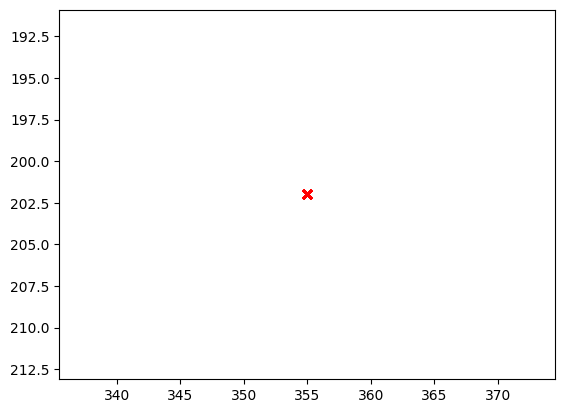

In [10]:
position_estimate =  start
theta_estimate = robot[2]


plt.gca().invert_yaxis()
speed_l = speed_r = 0
min_distance = 30
dt = 0.01
position_history = []
theta_history = []

for target in path:
    distance = np.sqrt((target[0] - position_estimate[0])**2 + (target[1] - position_estimate[1])**2)
    print(distance)
    while distance > min_distance:
        
        ret, frame = get_frame()

        if ret == True:
            position_measure, position_contour,_ = computer_vision(frame, 'robot', False)
            position_measure = position_measure[0]
            if position_measure is not None:
                _, theta_measure = get_robot_position(frame, position_measure, position_contour)
        
        #position_history.append(position_measure)
        #theta_history.append(theta_measure)
        print(position_measure, theta_measure)
        time.sleep(dt)



    